<a href="https://colab.research.google.com/github/Dhairyaxshah/Appfluence/blob/main/notebooks/03_supervised_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supervised Machine Learning: App Popularity Prediction

This notebook builds supervised machine learning models to predict app popularity
based on cleaned Google Play Store and Apple App Store datasets.

Exploratory Data Analysis (EDA) and data cleaning were performed in a separate notebook.
Insights from EDA guide feature selection and modeling decisions in this notebook.


In [34]:
import pandas as pd
import numpy as np

# gp = google playstore
#as = app store
gp_url = "https://raw.githubusercontent.com/Dhairyaxshah/Appfluence/main/data/google_play_cleaned.csv"
as_url = "https://raw.githubusercontent.com/Dhairyaxshah/Appfluence/main/data/apple_store_cleaned.csv"

df_gp = pd.read_csv(gp_url)
df_as = pd.read_csv(as_url)

df_gp.shape, df_as.shape
# This code confirms that i dont need to do cleaning again


((8196, 10), (7195, 10))

## Problem Definition

The goal is to predict app popularity using supervised machine learning.

- For Google Play Store, popularity is measured using install counts.
- Due to extreme skew in install values (confirmed via EDA), a classification
  approach is adopted instead of regression.

Apps are categorized into three popularity classes:
Low, Medium, and High.


In [35]:
#Create install_class column for google play
#use pd.cut()[creates bins of specified range] for creating col
#bins parameter defines ranges
#like 0 to 10^5 = low
#.max() is calculating absolute highest value from Installs col
#.value_counts() will count no. of apps falling Under low-high

df_gp['install_class'] = pd.cut(
    df_gp['Installs'],
    bins=[0, 1e5, 1e7, df_gp['Installs'].max()],
    labels=['Low', 'Medium', 'High']
)

df_gp['install_class'].value_counts()


,count
install_class,
Low,4299
Medium,3463
High,434


In [36]:
# For app store we will use user ratings
# create a popularity_class col in the dataset
# use pd.qcut()[divides your data into quantiles] to create col

df_as['popularity_class'] = pd.qcut(
    df_as['rating_count_tot'],

    #tells pd.qcut() to divide in three equal sized parts
    #you will observe that size of low ,medium , high is almost same
    q=3,
    labels=['Low', 'Medium', 'High']
)

df_as['popularity_class'].value_counts()


,count
popularity_class,
Low,2405
High,2399
Medium,2391


Feature Selection

In [37]:
# Feature Selection for Google Play store based on EDA
X_gp = df_gp[
    ['Rating', 'Reviews', 'Size', 'Price',
     'Type', 'Category', 'Content Rating']
]

y_gp = df_gp['install_class']


In [38]:
# Feature Selection for App Store based on EDA
X_as = df_as[
    ['price', 'size_mb', 'user_rating',
     'rating_count_ver', 'prime_genre',
     'cont_rating', 'lang.num']
]

y_as = df_as['popularity_class']


In [39]:
# Train-Test Split
from sklearn.model_selection import train_test_split

X_train_gp, X_test_gp, y_train_gp, y_test_gp = train_test_split(
    X_gp, y_gp,
    test_size=0.2,
    random_state=42,
    stratify=y_gp
)


In [40]:
# importing tools and algorithms from sklearn library
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


In [41]:
num_features = ['Rating', 'Reviews', 'Size', 'Price']
cat_features = ['Category', 'Content Rating', 'Type']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ]
)

In [42]:
X_gp.columns

Index(['Rating', 'Reviews', 'Size', 'Price', 'Type', 'Category',
       'Content Rating'],
      dtype='object')

In [43]:
log_model = Pipeline([
    ('preprocess', preprocessor),
    ('clf', LogisticRegression(max_iter=2000, solver='lbfgs', class_weight= 'balanced'))
])

log_model.fit(X_train_gp, y_train_gp)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Rating', 'Reviews', 'Size',
                                                   'Price']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Category', 'Content Rating',
                                                   'Type'])])),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=2000))])

In [44]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
    log_model,
    X_gp,
    y_gp,
    cv=5,
    scoring='f1_macro'
)

print("Mean CV F1-score:", cv_scores.mean())


Mean CV F1-score: 0.6786621966257755


In [45]:
#making predictions on test data
y_pred_gp = log_model.predict(X_test_gp)


In [46]:
#evaluating the performance
y_pred_gp = log_model.predict(X_test_gp)
from sklearn.metrics import accuracy_score, classification_report

print("Accuracy:", accuracy_score(y_test_gp, y_pred_gp))
print(classification_report(y_test_gp, y_pred_gp))

Accuracy: 0.7615853658536585
              precision    recall  f1-score   support

        High       0.71      0.82      0.76        87
         Low       0.77      0.85      0.81       860
      Medium       0.76      0.65      0.70       693

    accuracy                           0.76      1640
   macro avg       0.75      0.77      0.75      1640
weighted avg       0.76      0.76      0.76      1640



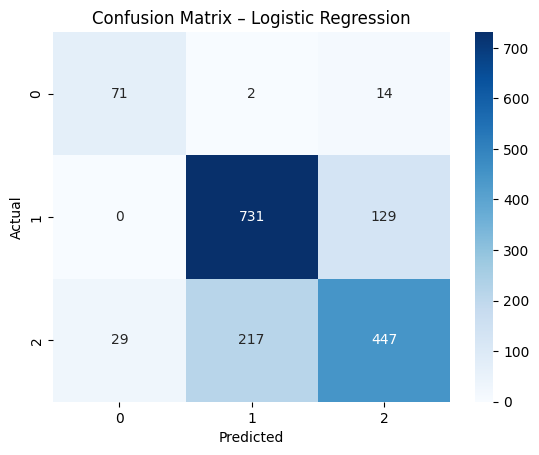

In [47]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_gp, y_pred_gp)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix – Logistic Regression')
plt.show()


In [48]:
from sklearn.metrics import roc_auc_score

# Get probabilities for ALL classes
y_prob_gp = log_model.predict_proba(X_test_gp)

# Multiclass ROC-AUC using One-vs-Rest
roc_auc = roc_auc_score(
    y_test_gp,
    y_prob_gp,
    multi_class='ovr',
    average='macro'
)

roc_auc


np.float64(0.8891620408576285)

In [49]:
feature_names = (
    log_model.named_steps['preprocess']
    .get_feature_names_out()
)

coefficients = log_model.named_steps['clf'].coef_[0]

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False)

coef_df.head(10)


,Feature,Coefficient
1,num__Reviews,12.447991
35,cat__Category_VIDEO_PLAYERS,1.265820
29,cat__Category_PRODUCTIVITY,1.240112
33,cat__Category_TOOLS,1.050161
4,cat__Category_ART_AND_DESIGN,1.002735
13,cat__Category_ENTERTAINMENT,0.981541
28,cat__Category_PHOTOGRAPHY,0.890293
34,cat__Category_TRAVEL_AND_LOCAL,0.826302
8,cat__Category_BUSINESS,0.768236
43,cat__Type_Free,0.728193


In [50]:
from sklearn.ensemble import RandomForestClassifier

rf_model = Pipeline([
    ('preprocess', preprocessor),
    ('clf', RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        class_weight='balanced'
    ))
])

rf_model.fit(X_train_gp, y_train_gp)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Rating', 'Reviews', 'Size',
                                                   'Price']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Category', 'Content Rating',
                                                   'Type'])])),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=200, random_state=42))])

In [51]:
importances = rf_model.named_steps['clf'].feature_importances_

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

importance_df.head(10)


,Feature,Importance
1,num__Reviews,0.662093
2,num__Size,0.114019
0,num__Rating,0.081358
18,cat__Category_GAME,0.011718
43,cat__Type_Free,0.011696
3,num__Price,0.010006
44,cat__Type_Paid,0.009136
15,cat__Category_FAMILY,0.007931
33,cat__Category_TOOLS,0.007672
38,cat__Content Rating_Everyone,0.005914
